## Prep to run this notebook:
- python scripts/run_vk_ref_geuvadis.py
- python scripts/run_vk_count_geuvadis.py
- python scripts/run_vk_count_geuvadis_wxs.py

In [1]:
# try:
#     import varseek as vk
# except ImportError:
#     print("varseek not found, installing...")
#     !pip install -U -q varseek
# try:
#     import RLSRWP_2025
# except ImportError:
#     print("RLSRWP_2025 not found, installing...")
#     !pip install -q git+https://github.com/pachterlab/RLSRWP_2025.git

In [2]:
from matplotlib_venn import venn2
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import shutil
import seaborn as sns
import re
from collections import Counter
import anndata as ad
from scipy import sparse
import scanpy as sc
from sklearn.metrics import silhouette_score

import varseek as vk
from RLSRWP_2025.constants import box_links_dict

RLSRWP_2025_dir = os.path.dirname(os.path.abspath(""))  # if this notebook resides in RLSRWP_2025/notebooks/0_data_download.ipynb, then this retrieves RLSRWP_2025
data_dir = os.path.join(RLSRWP_2025_dir, "data")

In [3]:
sequencing_data_out_base = os.path.join(data_dir, "geuvadis_data_base")
geuvadis_reference_files_dir = os.path.join(data_dir, "reference", "geuvadis")
variants_transcriptome_df_path = os.path.join(geuvadis_reference_files_dir, "variants_transcriptome.parquet")

geuvadis_genotype_true_adata = os.path.join(geuvadis_reference_files_dir, "genotypes_adata_true.h5ad")
adata_combined_path_reference_genome = os.path.join(sequencing_data_out_base, "adata_reference_genome_combined.h5ad")
adata_combined_path_vcrs_final = os.path.join(sequencing_data_out_base, f"adata_vcrs_combined_w37_k41.h5ad")

reference_dir = os.path.join(RLSRWP_2025_dir, "data", "reference")
t2g_file = os.path.join(reference_dir, "ensembl_grch37_release113", "t2g.txt")

downsampled_fractions = [0.0001, 0.001, 0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64, 1.0]  # [0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64, 1.0]
min_counts = 2
min_samples_per_variant = 3
n_top_variants = 2000
gene_set_to_exclude = {'ENSG00000111640', 'ENSG00000242580', 'ENSG00000243466', 'ENST00000603632', 'ENST00000605760'}  # None, or a set of gene names to exclude from the analysis (in ENSGs)

out_dir = os.path.join(data_dir, "geuvadis_analysis_total")

In [4]:
if not os.path.isfile(adata_combined_path_reference_genome):
    vk.utils.download_box_url(box_links_dict["geuvadis_adata_reference_genome"], output_file_name=adata_combined_path_reference_genome)
if not os.path.isfile(geuvadis_genotype_true_adata):
    vk.utils.download_box_url(box_links_dict["geuvadis_adata_genotype"], output_file_name=geuvadis_genotype_true_adata)
if not os.path.isfile(adata_combined_path_vcrs_final):
    vk.utils.download_box_url(box_links_dict[f"geuvadis_adata_vcrs_w37_k41"], output_file_name=adata_combined_path_vcrs_final)

adata_reference = ad.read_h5ad(adata_combined_path_reference_genome)
adata_genotype = ad.read_h5ad(geuvadis_genotype_true_adata)
adata_vcrs = ad.read_h5ad(adata_combined_path_vcrs_final)

os.makedirs(out_dir, exist_ok=True)

In [5]:
adata_vcrs

AnnData object with n_obs × n_vars = 666 × 178549
    obs: 'experiment_alias_underscores_only', 'experiment_accession', 'library_strategy', 'sample_title', 'Sex', 'Biosample ID', 'Population name', 'Superpopulation name'

In [6]:
adata_reference

AnnData object with n_obs × n_vars = 666 × 57905
    obs: 'experiment_alias_underscores_only', 'experiment_accession', 'library_strategy', 'sample_title', 'Sex', 'Biosample ID', 'Population name', 'Superpopulation name'

In [7]:
adata_genotype

AnnData object with n_obs × n_vars = 1092 × 203850
    var: 'has_id', 'ID', 'variant_header'

## Which samples were excluded due to faulty FASTQs?

In [8]:
# 1. Get all child directory names
all_dirs = [
    name for name in os.listdir(sequencing_data_out_base)
    if os.path.isdir(os.path.join(sequencing_data_out_base, name)) and name.startswith("E_GEUV_1")
]

# 2. Get the list of experiment aliases from AnnData
aliases_in_adata = set(adata_vcrs.obs['experiment_alias_underscores_only'].unique())

# 3. Get directories not listed in adata
unmatched_dirs = [d for d in all_dirs if d not in aliases_in_adata]
unmatched_dirs

[]

## PP

#### Drop duplicates from adata_vcrs

In [9]:
adata_vcrs = adata_vcrs[~adata_vcrs.obs['sample_title'].duplicated(keep='first')].copy()

In [10]:
print(adata_vcrs.obs['Superpopulation name'].value_counts())
adata_vcrs.obs['Superpopulation name'] = adata_vcrs.obs['Superpopulation name'].replace(
    'European Ancestry,West Eurasia (SGDP)', 'European Ancestry'
)

print(adata_vcrs.obs['Population name'].value_counts())
adata_vcrs.obs['Population name'] = adata_vcrs.obs['Population name'].replace({
    'British,English': 'British',
    'Finnish,Finnish': 'Finnish'
})

Superpopulation name
European Ancestry                        371
African Ancestry                          89
European Ancestry,West Eurasia (SGDP)      4
Name: count, dtype: int64
Population name
British            93
Finnish            93
Toscani            93
CEPH               92
Yoruba             89
British,English     2
Finnish,Finnish     2
Name: count, dtype: int64


In [11]:
if not os.path.isfile(variants_transcriptome_df_path):
    vk.utils.download_box_url(box_links_dict["geuvadis_variants"], output_file_name=variants_transcriptome_df_path)

variants_transcriptome_df = pd.read_parquet(variants_transcriptome_df_path)
variants_transcriptome_df['variant_header_cdna'] = variants_transcriptome_df['transcript_ID'] + ":" + variants_transcriptome_df['variant_cdna']
adata_genotype.obs['sample_title'] = adata_genotype.obs.index.astype(str).str.slice(2)
adata_genotype.var = adata_genotype.var.merge(variants_transcriptome_df[["variant_header", "variant_header_cdna"]], how="left", on="variant_header")
adata_genotype.var.rename(columns={"variant_header": "variant_header_cds", "variant_header_cdna": "variant_header"}, inplace=True)
adata_genotype.obs = adata_genotype.obs.merge(adata_vcrs.obs[['sample_title', 'Sex', 'Population name', 'Superpopulation name']].drop_duplicates(subset='sample_title'), on='sample_title', how='left')
adata_genotype.var.index = adata_genotype.var.index.astype(str)  # otherwise I get AssertionError: Don’t call _normalize_index with non-categorical/string names
adata_genotype.obs.index = adata_genotype.obs.index.astype(str)

adata_reference.var['gene'] = adata_reference.var.index.str.split(".").str[0]
t2g_dict = vk.utils.make_t2g_dict(t2g_file, strip_versions=True)
t2g_dict_gene_names = vk.utils.make_t2g_dict(t2g_file, strip_versions=True, column_indices=(0,2))

/home/jmrich/Desktop/varseek/varseek/utils/varseek_clean_utils.py:2277: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  t2g_df = pd.read_csv(t2g_file, sep="\t", header=None)
/home/jmrich/Desktop/varseek/varseek/utils/varseek_clean_utils.py:2277: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  t2g_df = pd.read_csv(t2g_file, sep="\t", header=None)


In [12]:
adata_vcrs = adata_vcrs[:, ~adata_vcrs.var_names.str.contains(";")]   # Remove columns (variants) with semicolon in name

if "transcript_ID" not in adata_vcrs.var.columns:
    adata_vcrs.var['transcript_ID'] = [idx.split(':')[0] for idx in adata_vcrs.var_names]

if "gene_id" not in adata_vcrs.var.columns:
    adata_vcrs.var["gene_id"] = adata_vcrs.var["transcript_ID"].map(t2g_dict).fillna(adata_vcrs.var["transcript_ID"])

if "gene_name" not in adata_vcrs.var.columns:
    adata_vcrs.var["gene_name"] = adata_vcrs.var["transcript_ID"].map(t2g_dict_gene_names)
    print(f"Number of missing gene names: {adata_vcrs.var['gene_name'].isna().sum()}")

if "vcrs_header_with_gene_name" not in adata_vcrs.var.columns:
    gene_name = adata_vcrs.var["gene_name"]
    index_parts = adata_vcrs.var.index.str.split(":")
    vcrs_header_with_gene_name = gene_name.astype(str) + "(" + index_parts.str[0] + "):" + index_parts.str[1]  # Build full string for non-NA gene names
    vcrs_header_with_gene_name[gene_name.isna()] = adata_vcrs.var.index[gene_name.isna()]  # Replace where gene_name is NA with just the index
    adata_vcrs.var['vcrs_header_with_gene_name'] = vcrs_header_with_gene_name

if min_counts is not None:
    adata_vcrs.X = adata_vcrs.X.multiply(adata_vcrs.X >= min_counts)

if "variant_count" not in adata_vcrs.var.columns:
    adata_vcrs.var["variant_count"] = adata_vcrs.X.sum(axis=0).A1 if hasattr(adata_vcrs.X, "A1") else np.asarray(adata_vcrs.X.sum(axis=0)).flatten()

Number of missing gene names: 5985


### Ensure adata_genotype is aligned with adata_vcrs

In [13]:
# # 1. Get variant headers from genotype
# variant_headers = adata_genotype.var['variant_header'].values
# header_set = set(variant_headers)

# # 2. Ensure all vcrs variants are present in genotype
# missing = [v for v in adata_vcrs.var.index if v not in header_set]
# if missing:
#     print(f"{len(missing)} variants in adata_vcrs.var.index were not found in adata_genotype.var['variant_header'] and will be removed.")
#     adata_vcrs = adata_vcrs[:, ~adata_vcrs.var.index.isin(missing)].copy()

# # 3. Find indices in the correct order
# variant_to_col = {v: i for i, v in enumerate(variant_headers)}
# cols_to_keep = [variant_to_col[v] for v in adata_vcrs.var.index]

# # 4. Subset adata_genotype to match the order
# adata_genotype = adata_genotype[:, cols_to_keep].copy()

# if "transcript_ID" not in adata_genotype.var.columns:
#     adata_genotype.var['transcript_ID'] = [header.split(':')[0] for header in adata_genotype.var['variant_header']]

# if "gene_id" not in adata_genotype.var.columns:
#     adata_genotype.var["gene_id"] = adata_genotype.var["transcript_ID"].map(t2g_dict).fillna(adata_genotype.var["transcript_ID"])

# if "gene_name" not in adata_genotype.var.columns:
#     adata_genotype.var["gene_name"] = adata_genotype.var["transcript_ID"].map(t2g_dict_gene_names)
#     print(f"Number of missing gene names: {adata_genotype.var['gene_name'].isna().sum()}")

# keep only overlapping obs
vcrs_titles = set(adata_vcrs.obs['sample_title'])
genotype_titles = set(adata_genotype.obs['sample_title'])

missing = vcrs_titles - genotype_titles
if missing:
    print(f"{len(missing)} samples in adata_vcrs.obs['sample_title'] were not found in adata_genotype.obs['sample_title'].")

adata_genotype = adata_genotype[adata_genotype.obs['sample_title'].isin(adata_vcrs.obs['sample_title'])].copy()

41 samples in adata_vcrs.obs['sample_title'] were not found in adata_genotype.obs['sample_title'].


In [14]:
if gene_set_to_exclude is not None:
    adata_vcrs = adata_vcrs[:, ~adata_vcrs.var['transcript_ID'].isin(gene_set_to_exclude).values]
    adata_vcrs = adata_vcrs[:, ~adata_vcrs.var['gene_id'].isin(gene_set_to_exclude).values]
    # adata_genotype = adata_genotype[:, ~adata_genotype.var['transcript_ID'].isin(gene_set_to_exclude).values]
    # adata_genotype = adata_genotype[:, ~adata_genotype.var['gene_id'].isin(gene_set_to_exclude).values]

In [15]:
adata_vcrs_without_CEPH = adata_vcrs[adata_vcrs.obs['Population name'] != 'CEPH'].copy()
adata_vcrs_without_African = adata_vcrs[adata_vcrs.obs['Superpopulation name'] != 'African Ancestry'].copy()

## Each sample is a "cell", and each variant is a "gene"

In [16]:
def plot_pca(adata, min_samples_per_variant=3, log_adata=False, n_top_variants=None, batch_key=None, do_scaling=False, mean_centering=False, n_pcs=50, size=12, remove_outliers=False, use_binary_matrix=False, save_prefix=None):
    adata = adata.copy()
    adata_original = adata.copy()
    if use_binary_matrix:
        adata.X = (adata.X > 0).astype(int)
        if log_adata or do_scaling:
            print("Binary matrix means do not log1p or scale")
        log_adata = False
        if do_scaling:
            mean_centering = True
        do_scaling = False
    if do_scaling and mean_centering:
        print("Mean scaling and scaling are mutually exclusive, setting mean_centering to False")
        mean_centering = False
    sc.pp.filter_genes(adata, min_cells=min_samples_per_variant)
    if log_adata:
        sc.pp.log1p(adata)
    if n_top_variants is not None:
        sc.pp.highly_variable_genes(adata, n_top_genes=n_top_variants, batch_key=batch_key)  # batch_key="Population name"
    if do_scaling:
        adata.raw = adata.copy()
        sc.pp.scale(adata, max_value=None)
    if mean_centering:
        if sparse.issparse(adata.X):
            means = np.array(adata.X.mean(axis=0)).ravel()
            adata.X = adata.X - means  # sparse broadcast
        else:
            adata.X = adata.X - adata.X.mean(axis=0)

    sc.tl.pca(adata)
    if remove_outliers:  # removes outlier greater than 5 standard deviations from the mean in PC1
        pc1 = adata.obsm['X_pca'][:, 0]
        z_scores = np.abs((pc1 - pc1.mean()) / pc1.std())
        threshold = 5
        keep_cells = z_scores <= threshold
        adata = adata_original[keep_cells].copy()
        plot_pca(adata=adata, min_samples_per_variant=min_samples_per_variant, log_adata=log_adata, n_top_variants=n_top_variants, batch_key=batch_key, do_scaling=do_scaling, mean_centering=mean_centering, n_pcs=n_pcs, size=size, remove_outliers=False, use_binary_matrix=use_binary_matrix)
        return adata
    
    save = save_prefix is not None

    sc.pl.pca_variance_ratio(adata, n_pcs=n_pcs, log=True, save=save)
    if save:
        current_path = os.path.join(os.getcwd(), "figures", "pca_variance_ratio.pdf")
        out_path = f"{save_prefix}_pca_variance_ratio.pdf" if save_prefix else "pca_variance_ratio.pdf"
        shutil.move(current_path, out_path)

    sc.pl.pca(
        adata,
        color=["Superpopulation name"],
        dimensions=[(0, 1)],
        size=size,
        save=save
    )
    if save:
        current_path = os.path.join(os.getcwd(), "figures", "pca.pdf")
        out_path = f"{save_prefix}_pca_superpopulation.pdf" if save_prefix else "pca_superpopulation.pdf"
        shutil.move(current_path, out_path)

    sc.pl.pca(
        adata,
        color=["Population name"],
        dimensions=[(0, 1)],
        size=size,
        save=save
    )
    if save:
        current_path = os.path.join(os.getcwd(), "figures", "pca.pdf")
        out_path = f"{save_prefix}_pca_population.pdf" if save_prefix else "pca_population.pdf"
        shutil.move(current_path, out_path)

    sc.pl.pca(
        adata,
        color=["Sex"],
        dimensions=[(0, 1)],
        size=size,
        save=save
    )
    if save:
        current_path = os.path.join(os.getcwd(), "figures", "pca.pdf")
        out_path = f"{save_prefix}_pca_sex.pdf" if save_prefix else "pca_sex.pdf"
        shutil.move(current_path, out_path)
    return adata


def plot_pc_loadings_line(adata, pc_index=0, out_path=None):
    pcs = adata.varm['PCs'][:, pc_index]

    # Get absolute loadings and sort descending
    abs_loadings = np.abs(pcs)
    sorted_loadings = np.sort(abs_loadings)[::-1]

    # remove 0s
    sorted_loadings = sorted_loadings[sorted_loadings > 0]

    # Plot
    plt.figure(figsize=(8, 4))
    plt.plot(sorted_loadings, marker='o', linewidth=1)
    plt.title(f'Absolute PCA Loadings (Descending) for PC{pc_index + 1}')
    plt.xlabel('Rank')
    plt.ylabel('Absolute Loading')
    plt.tight_layout()
    if out_path:
        plt.savefig(out_path, bbox_inches='tight')
    plt.show()
    plt.close()


def plot_pc_loadings(adata, pc_index=0, n_top=10, colors=('#1f77b4', '#ff7f0e'), out_path=None):  # (e.g., PC1 = 0)
    pcs = adata.varm['PCs'][:, pc_index]

    # Get top 10 absolute loadings, keeping sign
    top10_idx = np.argsort(np.abs(pcs))[-n_top:][::-1]
    top10_variants = adata.var['vcrs_header_with_gene_name'].iloc[top10_idx]  # adata.var_names[top10_idx]
    top10_values = pcs[top10_idx]

    # Create DataFrame
    df = pd.DataFrame({
        'Variant': top10_variants,
        'PC_loading': top10_values
    })

    if len(colors) == 1:
        pass
    elif len(colors) == 2:
        colors = [colors[0] if v >= 0 else colors[1] for v in df['PC_loading']]
    else:
        raise ValueError("colors should be a single color or a list of two colors.")

    # Plot
    plt.figure(figsize=(8, 4))
    plt.bar(df['Variant'], df['PC_loading'], color=colors)
    plt.axhline(0, color='black', linewidth=0.8)
    plt.xticks(rotation=90, ha='right', fontsize=8)
    plt.ylabel(f'PC{pc_index + 1} loading')
    plt.title(f'Top 10 Variants by PC{pc_index + 1} Loading (Signed)')
    plt.tight_layout()
    if out_path:
        plt.savefig(out_path, bbox_inches='tight')
    plt.show()
    plt.close()

    return df

def get_genes_of_top_pc_loadings(adata, pc_index=0, n_top=100):
    pcs = adata.varm['PCs'][:, pc_index]

    # Get top 10 absolute loadings, keeping sign
    top10_idx = np.argsort(np.abs(pcs))[-n_top:][::-1]
    genes_of_top10_variants = adata.var['gene_name'].iloc[top10_idx]  # adata.var_names[top10_idx]
    filtered_genes = [g for g in genes_of_top10_variants if not pd.isna(g)]
    gene_counts = Counter(filtered_genes)
    sorted_counts = gene_counts.most_common()
    return sorted_counts

### Binarize

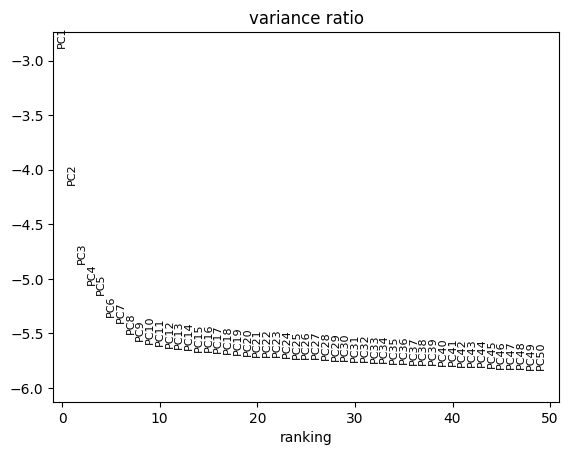

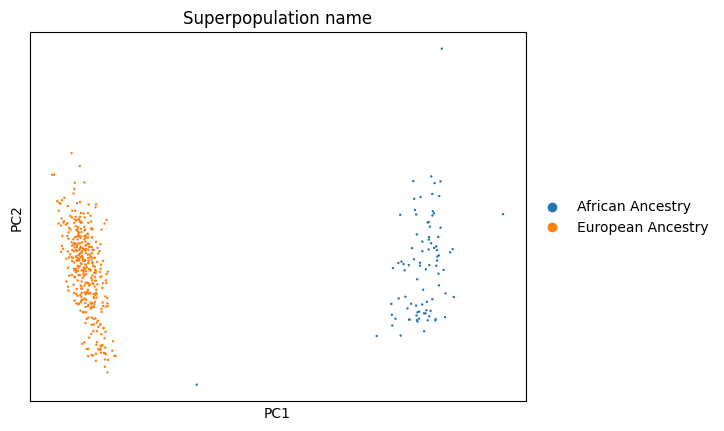

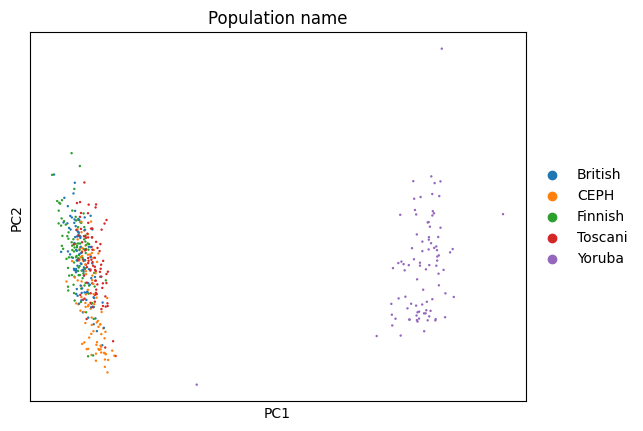

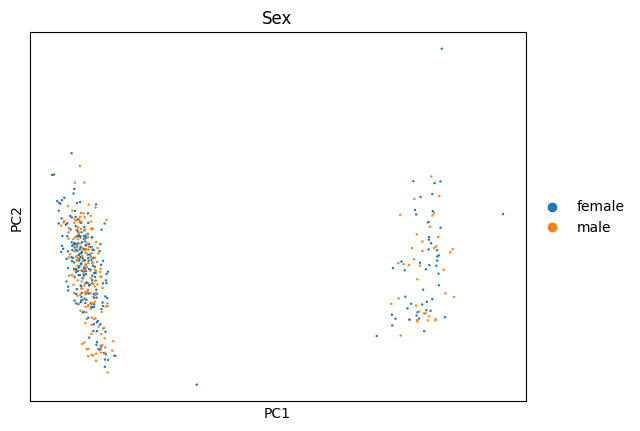

In [17]:
adata_vcrs_output = plot_pca(adata_vcrs, min_samples_per_variant=min_samples_per_variant, log_adata=False, n_top_variants=None, batch_key=None, do_scaling=False, n_pcs=50, size=12, use_binary_matrix=True, mean_centering=False, save_prefix=os.path.join(out_dir, "variants_binarized"))

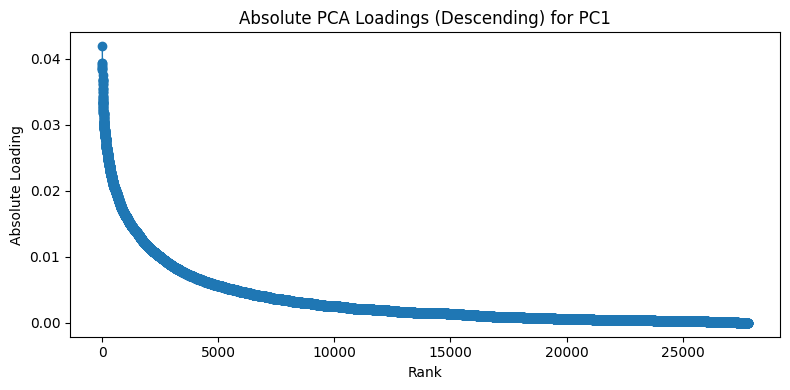

In [18]:
plot_pc_loadings_line(adata_vcrs_output, pc_index=0, out_path=os.path.join(out_dir, "pc_loadings_line_pc1.pdf"))

## 500 seems like a good cutoff

In [19]:
print(get_genes_of_top_pc_loadings(adata_vcrs_output, pc_index=0, n_top=500))

[('ALMS1', 9), ('SDHA', 5), ('SPATA5L1', 4), ('PCNT', 4), ('DNHD1', 4), ('GPATCH1', 4), ('UBD', 3), ('DHRS7', 3), ('FANCI', 3), ('PPP1R15A', 3), ('LRRK1', 3), ('HTT', 3), ('CNTRL', 3), ('TMCO3', 3), ('ZBED5', 3), ('TTLL5', 2), ('SLC39A14', 2), ('FAIM', 2), ('RNF135', 2), ('DHRS4', 2), ('ATAD3B', 2), ('ADCK2', 2), ('IRF2BP2', 2), ('SCLY', 2), ('EP400', 2), ('HCST', 2), ('SLC25A37', 2), ('POLD1', 2), ('SNN', 2), ('PARVG', 2), ('CCDC88B', 2), ('CSTF2T', 2), ('FAM136A', 2), ('MCPH1', 2), ('STK36', 2), ('HLA-DPB1', 2), ('LMNA', 2), ('ZNF92', 2), ('TCHP', 2), ('LAP3', 2), ('SPTBN1', 2), ('RANBP6', 2), ('ATAD5', 2), ('TBC1D15', 2), ('PLEKHM2', 2), ('PLOD1', 2), ('CDK12', 2), ('SPATA20', 2), ('PDHX', 2), ('TRAF3IP3', 2), ('ZNF518B', 2), ('RPTOR', 2), ('KIAA0141', 2), ('ITPR3', 2), ('RNF213', 2), ('PHACTR4', 2), ('HIVEP1', 2), ('ZNF76', 2), ('CDC16', 2), ('PLA1A', 2), ('FUK', 2), ('OAS3', 2), ('MPG', 1), ('SCP2', 1), ('SLC25A19', 1), ('CRELD2', 1), ('AK4', 1), ('TBC1D10C', 1), ('ZSCAN25', 1), (

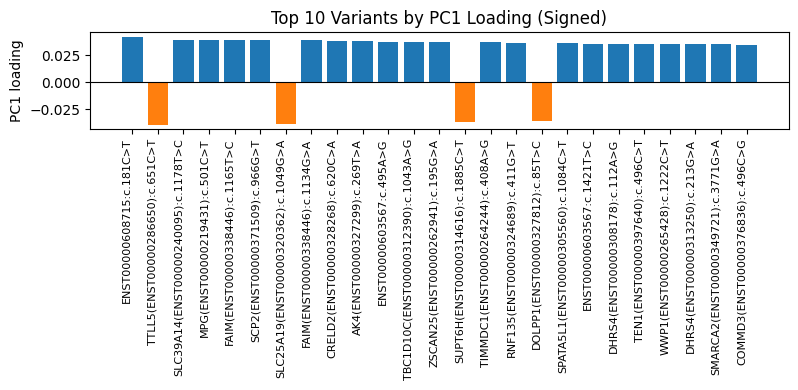

,Variant,PC_loading
variant,,
ENST00000608715:c.181C>T,ENST00000608715:c.181C>T,0.041927
ENST00000286650:c.651C>T,TTLL5(ENST00000286650):c.651C>T,-0.039332
ENST00000240095:c.1178T>C,SLC39A14(ENST00000240095):c.1178T>C,0.039330
ENST00000219431:c.501C>T,MPG(ENST00000219431):c.501C>T,0.039008
ENST00000338446:c.1165T>C,FAIM(ENST00000338446):c.1165T>C,0.038855
ENST00000371509:c.966G>T,SCP2(ENST00000371509):c.966G>T,0.038661
ENST00000320362:c.1049G>A,SLC25A19(ENST00000320362):c.1049G>A,-0.038598
ENST00000338446:c.1134G>A,FAIM(ENST00000338446):c.1134G>A,0.038452
ENST00000328268:c.620C>A,CRELD2(ENST00000328268):c.620C>A,0.038323


In [20]:
top_loadings_df = plot_pc_loadings(adata_vcrs_output, pc_index=0, n_top=25, out_path=os.path.join(out_dir, "pc_loadings_pc1.pdf"))
top_loadings_df

### Repeat for PC2

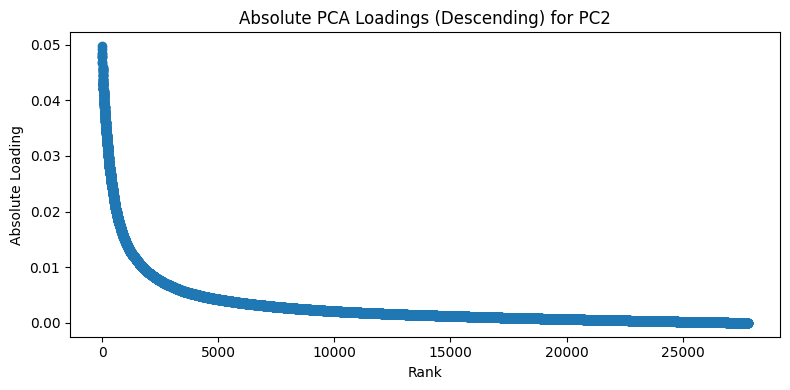

[('HSP90AB1', 27), ('ALDOA', 17), ('IGKV4-1', 10), ('RPL28', 8), ('RPL13A', 8), ('RPL11', 8), ('LDHA', 8), ('UBC', 7), ('RPL8', 7), ('RPS5', 6), ('EEF1B2', 6), ('RAN', 6), ('HLA-B', 6), ('RPL18A', 5), ('RPL14', 5), ('YBX1', 5), ('FTL', 5), ('EEF2', 5), ('PABPC3', 5), ('HLA-DRA', 5), ('EIF4A1', 5), ('IGLV2-14', 5), ('IGLV3-1', 5), ('RPS24', 4), ('RPL6', 4), ('RPL10A', 4), ('RPS3A', 4), ('HNRNPA1', 4), ('RPS12', 4), ('RPL35', 4), ('RPLP2', 4), ('RPL31', 4), ('HLA-DQA1', 4), ('CALR', 4), ('BTF3', 4), ('IFI30', 4), ('RPL34', 3), ('RPL38', 3), ('RPS7', 3), ('TUBA1C', 3), ('RPL27', 3), ('PFN1', 3), ('RPS27A', 3), ('RPL15', 3), ('PGAM1', 3), ('IGKC', 3), ('GNAS', 3), ('IGLV1-40', 3), ('RPL19', 2), ('TMSB10', 2), ('ARPC2', 2), ('RPL5', 2), ('NME1-NME2', 2), ('TRIM28', 2), ('RPL18', 2), ('RPSA', 2), ('RPL23A', 2), ('RPL39L', 2), ('TUBB', 2), ('RPL17', 2), ('LSP1', 2), ('EIF3L', 2), ('UBB', 2), ('RPS27', 2), ('GSTP1', 2), ('HLA-E', 2), ('IGLC7', 2), ('SRGN', 2), ('GPR56', 2), ('RPS15', 2), ('SUB

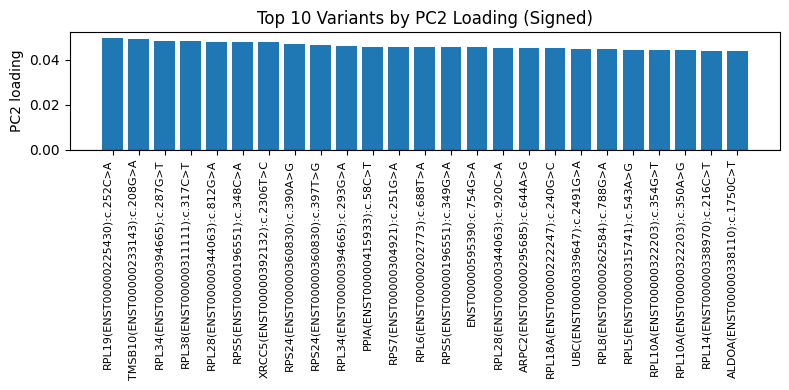

In [21]:
plot_pc_loadings_line(adata_vcrs_output, pc_index=1, out_path=os.path.join(out_dir, "pc_loadings_line_pc2.pdf"))
print(get_genes_of_top_pc_loadings(adata_vcrs_output, pc_index=1, n_top=500))
top_loadings_df2 = plot_pc_loadings(adata_vcrs_output, pc_index=1, n_top=25, out_path=os.path.join(out_dir, "pc_loadings_pc2.pdf"))

### Can we separate European subgroups if we take out African samples?

In [22]:
# adata_vcrs_output_without_African = plot_pca(adata_vcrs_without_African, min_samples_per_variant=min_samples_per_variant, log_adata=False, n_top_variants=n_top_variants, batch_key=None, do_scaling=False, n_pcs=50, size=18, use_binary_matrix=True, mean_centering=False)

Maybe slightly? But not much

### Compare to genotype

In [23]:
adata_genotype_without_CEPH = adata_genotype[adata_genotype.obs['Population name'] != 'CEPH'].copy()
adata_genotype_without_African = adata_genotype[adata_genotype.obs['Superpopulation name'] != 'African Ancestry'].copy()

In [24]:
# plot_pca(adata_genotype, min_samples_per_variant=min_samples_per_variant, log_adata=False, n_top_variants=None, batch_key=None, do_scaling=False, mean_centering=False, n_pcs=50, size=12)

In [25]:
# plot_pca(adata_genotype_without_CEPH, min_samples_per_variant=min_samples_per_variant, log_adata=False, n_top_variants=n_top_variants, batch_key=None, do_scaling=False, mean_centering=True, n_pcs=50, size=12)

In [26]:
# plot_pca(adata_genotype_without_African, min_samples_per_variant=min_samples_per_variant, log_adata=False, n_top_variants=n_top_variants, batch_key=None, do_scaling=False, mean_centering=True, n_pcs=50, size=12)

In [27]:
# if do_scaling:
#     adata_vcrs.raw.to_adata()

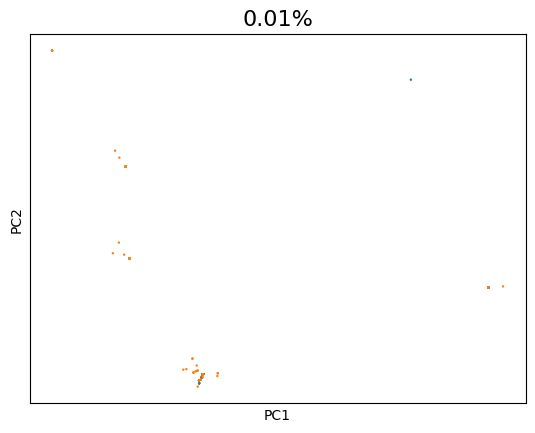

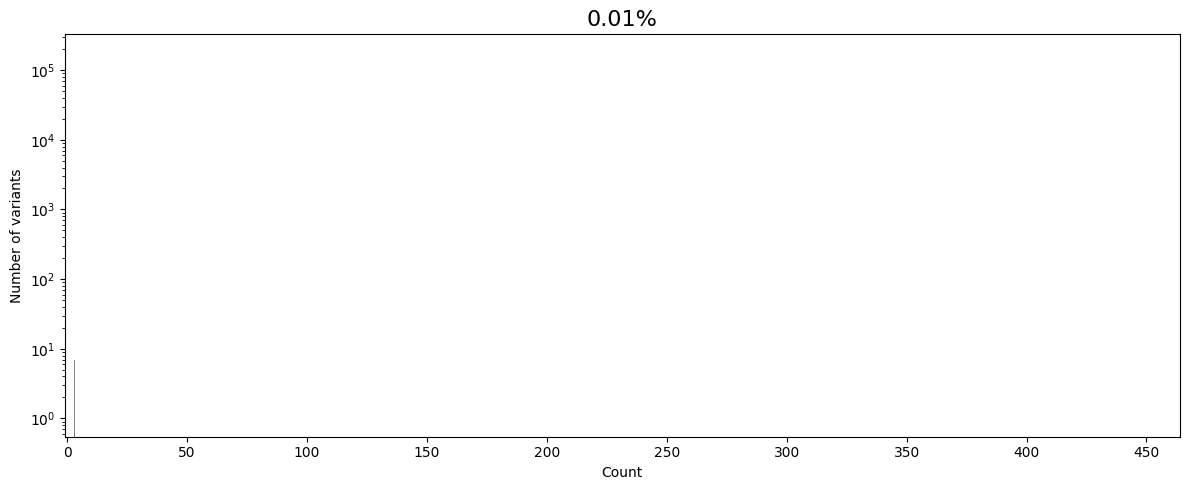

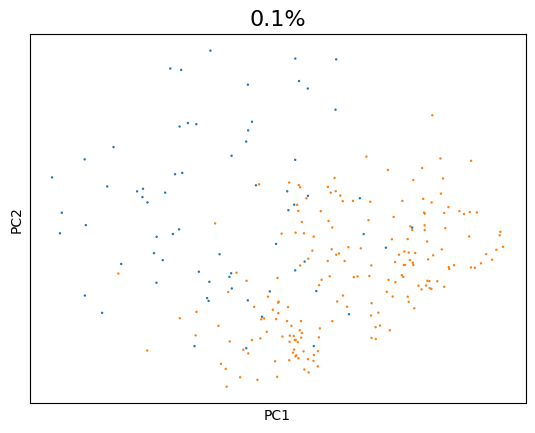

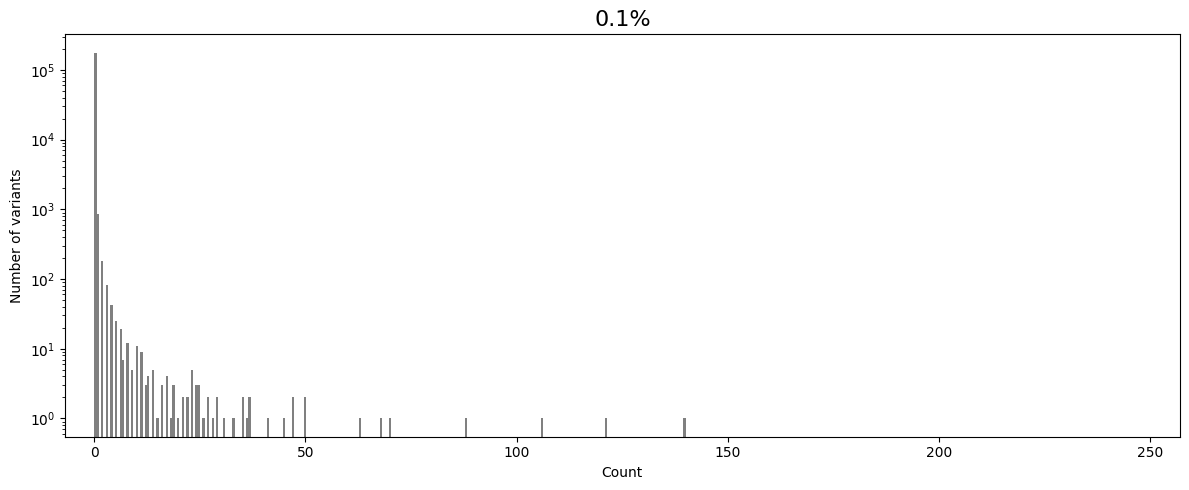

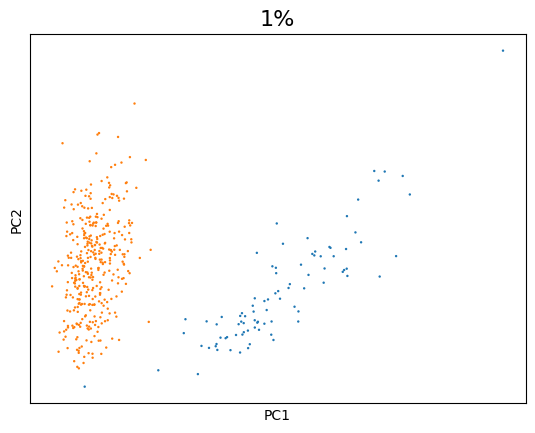

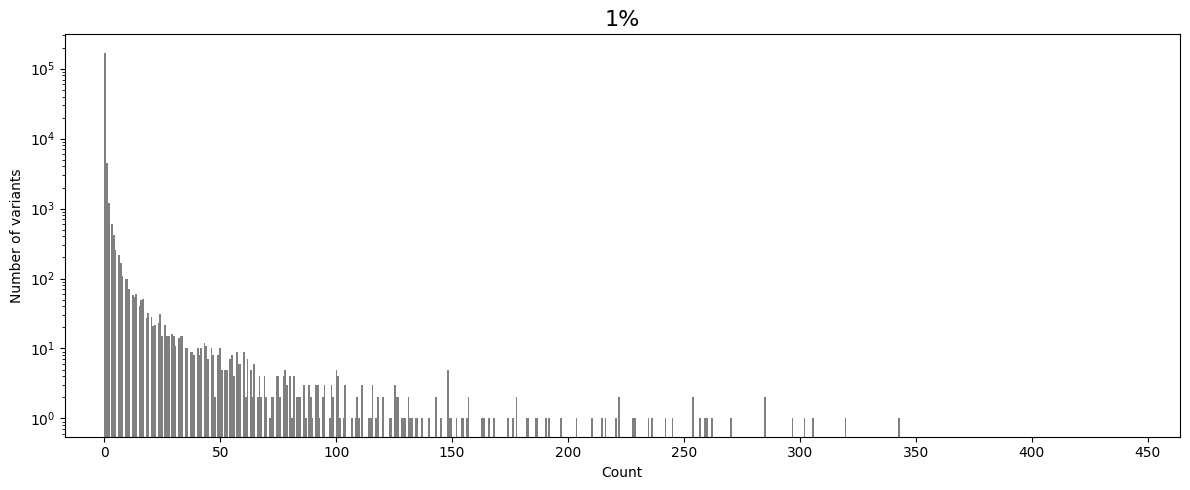

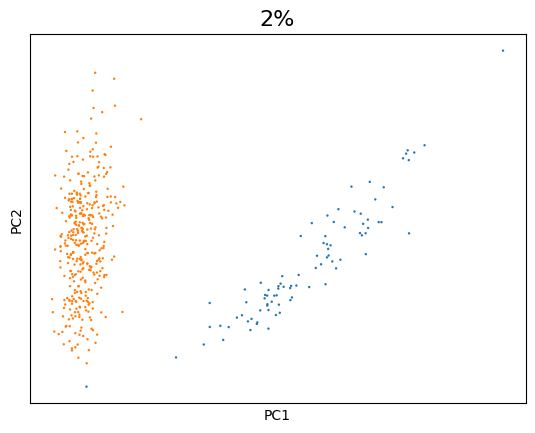

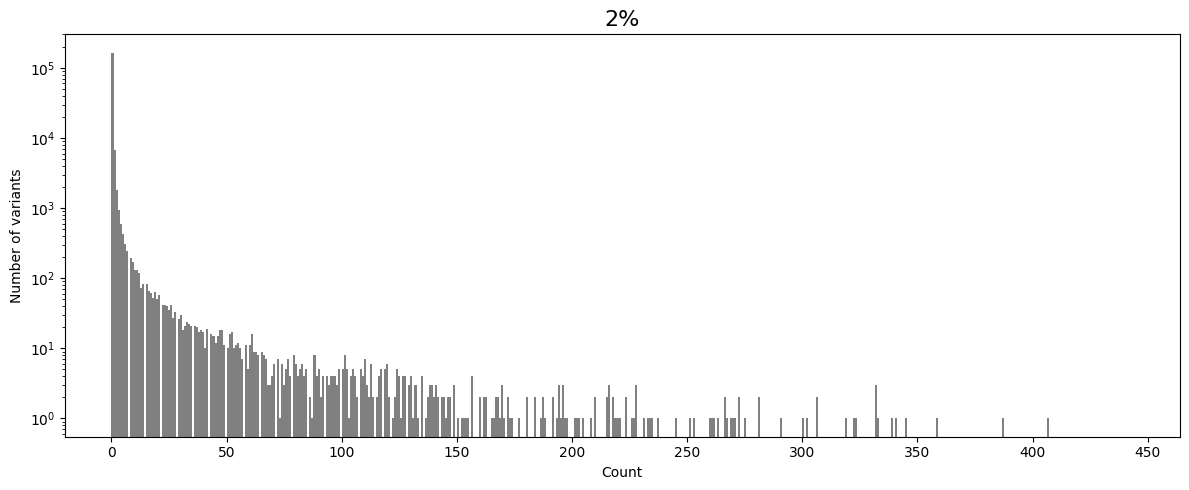

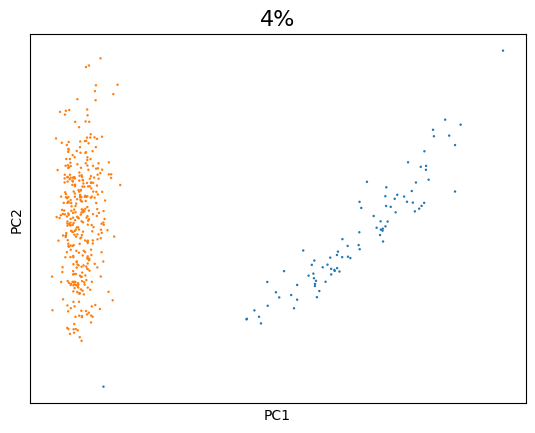

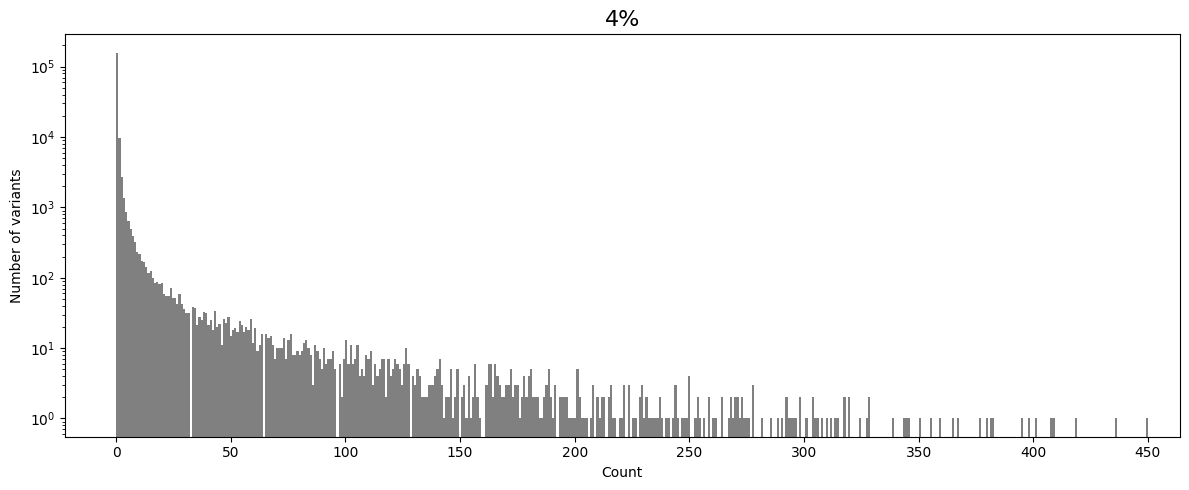

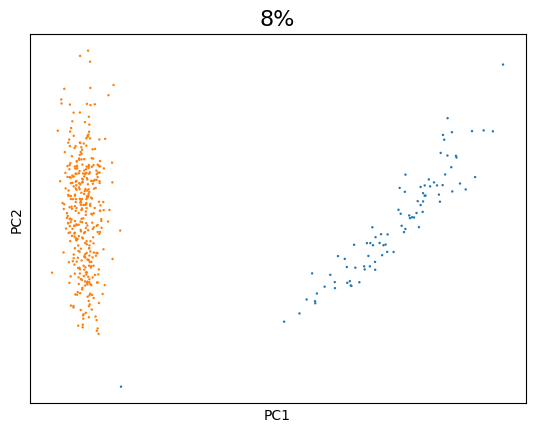

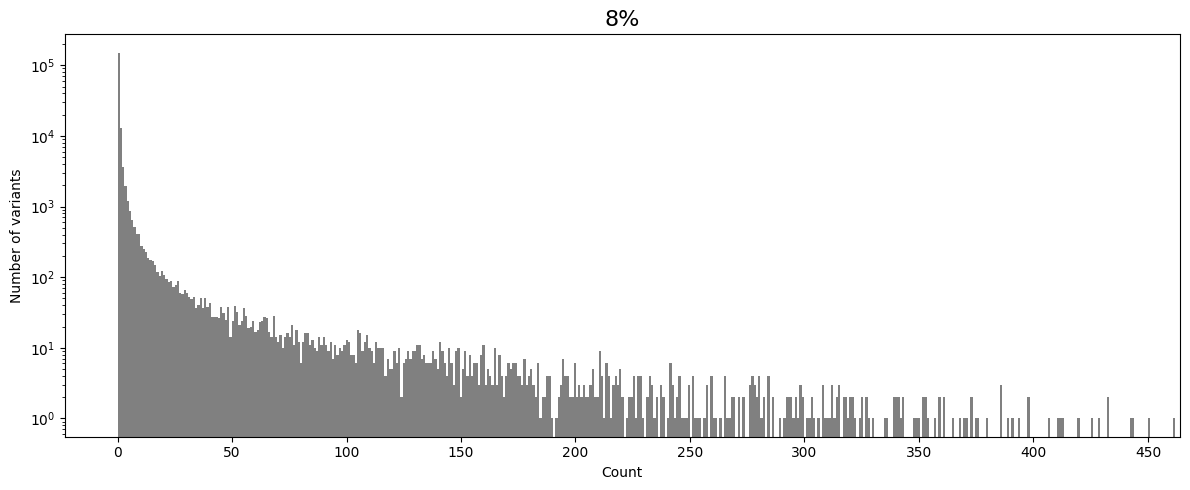

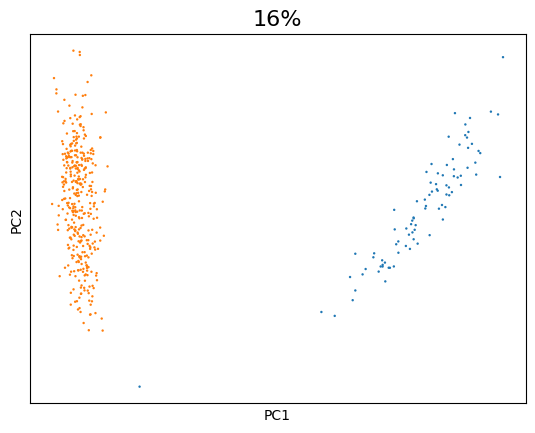

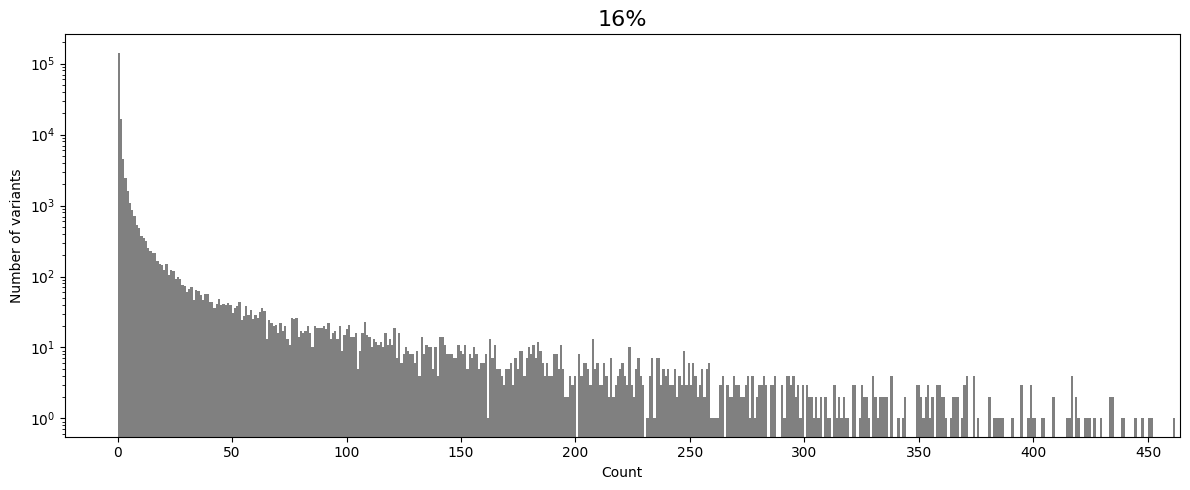

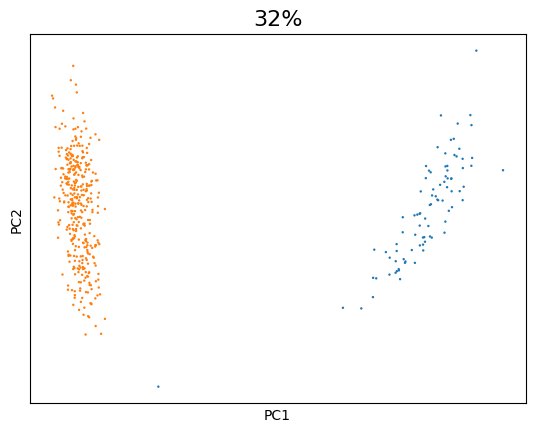

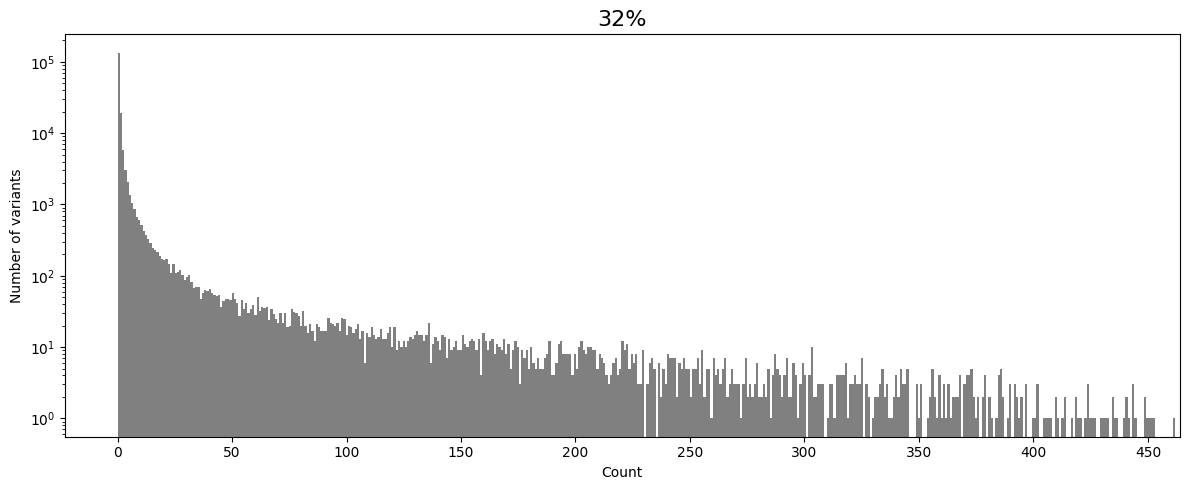

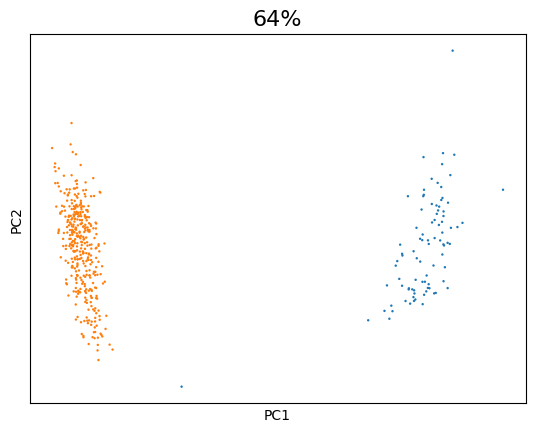

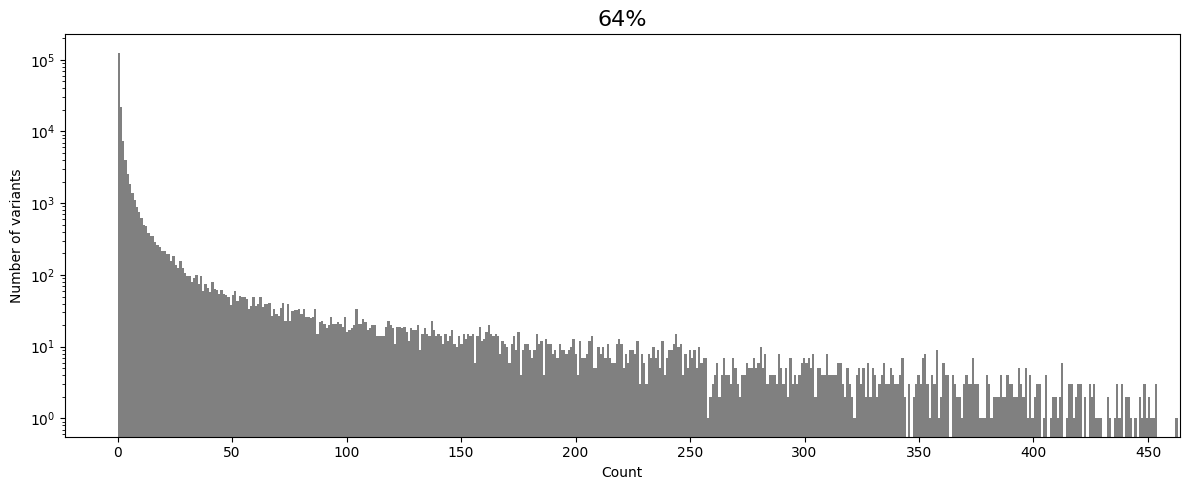

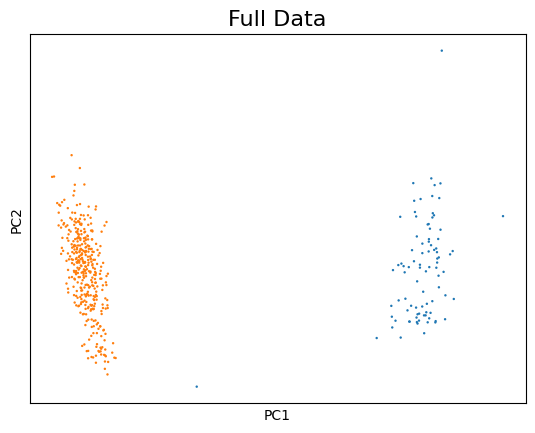

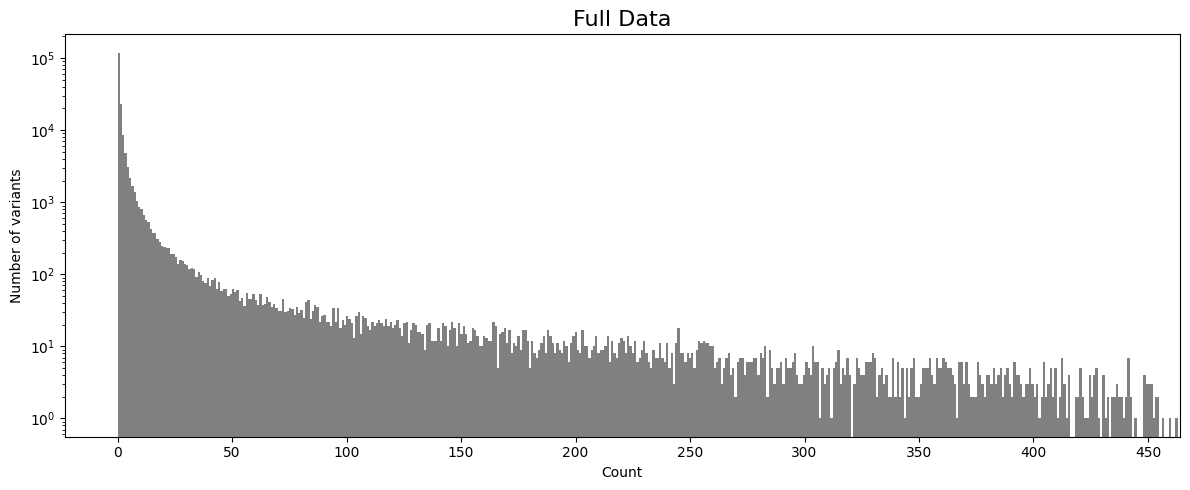

In [35]:
def do_cleaning(adata_vcrs, t2g_dict, min_counts=None, gene_set_to_exclude=None):
    adata_vcrs = adata_vcrs.copy()
    adata_vcrs = adata_vcrs[~adata_vcrs.obs['sample_title'].duplicated(keep='first')].copy()
    if min_counts is not None:
            adata_vcrs.X = adata_vcrs.X.multiply(adata_vcrs.X >= min_counts)
    adata_vcrs = adata_vcrs[:, ~adata_vcrs.var_names.str.contains(";")].copy()
    adata_vcrs.var['transcript_ID'] = [idx.split(':')[0] for idx in adata_vcrs.var_names]
    adata_vcrs.var["gene_id"] = adata_vcrs.var["transcript_ID"].map(t2g_dict).fillna(adata_vcrs.var["transcript_ID"])
    if gene_set_to_exclude is not None:
        adata_vcrs = adata_vcrs[:, ~adata_vcrs.var['transcript_ID'].isin(gene_set_to_exclude).values].copy()
        adata_vcrs = adata_vcrs[:, ~adata_vcrs.var['gene_id'].isin(gene_set_to_exclude).values].copy()
    adata_vcrs.var["variant_count"] = adata_vcrs.X.sum(axis=0).A1 if hasattr(adata_vcrs.X, "A1") else np.asarray(adata_vcrs.X.sum(axis=0)).flatten()
    adata_vcrs.obs['Superpopulation name'] = adata_vcrs.obs['Superpopulation name'].replace(
        'European Ancestry,West Eurasia (SGDP)', 'European Ancestry'
    )
    return adata_vcrs

def run_pca(adata_vcrs, min_samples_per_variant=3, plot_pca=True, pca_out=None, pca_title="PCA", legend_out=None):
    adata_vcrs = adata_vcrs.copy()
    adata_vcrs.X = (adata_vcrs.X > 0).astype(int)
    # Copy just for PCA
    adata_temp = adata_vcrs.copy()
    sc.pp.filter_genes(adata_temp, min_cells=min_samples_per_variant)
    sc.tl.pca(adata_temp)

    if pca_out is not None:
        plot_pca = True
    
    if plot_pca:    
        sc.pl.pca(
            adata_temp,
            color=["Superpopulation name"],
            dimensions=[(0, 1)],
            size=12,
            save=False,
            legend_loc=None,
            show=False
        )
        plt.gca().set_title(pca_title, fontsize=16)
        if pca_out is not None:
            plt.savefig(pca_out, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

        if legend_out is not None and not os.path.isfile(legend_out):
            sc.pl.pca(
                adata_temp,
                color="Superpopulation name",
                dimensions=[(0, 1)],
                size=0,
                show=False,
                save=False,
            )
            plt.savefig(legend_out, dpi=300, bbox_inches='tight')


    # Copy PCA result back to original
    adata_vcrs.obsm["X_pca"] = adata_temp.obsm["X_pca"]
    return adata_vcrs

def compute_superpopulation_separation_score(adata, num_pcs=10):
    X_pca = adata.obsm["X_pca"][:, :num_pcs]
    labels = adata.obs["Superpopulation name"].values

    sil_score = silhouette_score(X_pca, labels)
    return(sil_score)

def compute_recall(adata, nonzero_count_full):
    nonzero_count = (adata.var["variant_count"] != 0).sum()
    recall = nonzero_count / nonzero_count_full
    return recall

def make_count_histogram(adata, x_log = False, y_log = True, title = None, output_path = None):
    if title is None:
        title = "Variant counts histogram"
    counts = adata.X.sum(axis=0)
    if hasattr(counts, "A1"):
        counts = counts.A1
    else:
        counts = np.array(counts).ravel()

    number_samples = adata.shape[0]
    bins = number_samples
    
    plt.figure(figsize=(12,5))
    plt.hist(counts, bins=number_samples, color="grey")
    plt.title(title, fontsize=16)
    plt.xlabel("Count")
    plt.ylabel("Number of variants")
    
    if x_log:
        if x_log is True:
            x_log = 2
        plt.xscale('log', base=x_log)
    if y_log:
        if y_log is True:
            y_log = 10
        plt.yscale('log', base=y_log)
    
    plt.xlim(right=number_samples)
    plt.xticks(np.arange(0, number_samples, 50))

    plt.tight_layout()
    if output_path:
        plt.savefig(output_path, bbox_inches='tight')
    plt.show()
    plt.close()

nonzero_count_full = (adata_vcrs.var["variant_count"] != 0).sum()
legend_out = os.path.join(out_dir, "pca_superpopulation_legend.pdf")
superpopulation_separation_scores_dict = {}
recall_dict = {}
for downsampled_fraction in downsampled_fractions:
    downsampled_fraction_str = str(downsampled_fraction).replace('.', '_')
    if downsampled_fraction == 1.0:
        adata_path = os.path.join(sequencing_data_out_base, "adata_vcrs_combined_w37_k41.h5ad")
        pca_out = os.path.join(out_dir, "variants_binarized_pca_superpopulation.pdf")  # will override above (intentionally)
        pca_title = "Full Data"  # "PCA in variant space on all data"
        histogram_title = "Full Data"  # "Variant count histogram on all data"
    else:
        adata_path = os.path.join(sequencing_data_out_base, f"adata_vcrs_combined_w37_k41_downsampled_{downsampled_fraction_str}.h5ad")
        if not os.path.isfile(adata_path):
            vk.utils.download_box_url(box_links_dict[f"geuvadis_adata_vcrs_downsampled_{downsampled_fraction_str}"], output_file_name=adata_path)
        pca_out = os.path.join(out_dir, f"pca_downsampled_{downsampled_fraction_str}.pdf")
        pca_title = f"{100 * downsampled_fraction:.2g}%"  # f"PCA in variant space on {100 * downsampled_fraction:.2g}% of read data"
        histogram_title = f"{100 * downsampled_fraction:.2g}%"  # f"Variant count histogram on {100 * downsampled_fraction:.2g}% of read data"
    adata_tmp = ad.read_h5ad(adata_path)
    adata_tmp = do_cleaning(adata_tmp, t2g_dict=t2g_dict, min_counts=min_counts, gene_set_to_exclude=gene_set_to_exclude)
    adata_tmp = run_pca(adata_tmp, min_samples_per_variant=min_samples_per_variant, pca_out = pca_out, pca_title = pca_title, legend_out = legend_out)
    superpopulation_separation_scores_dict[downsampled_fraction] = compute_superpopulation_separation_score(adata_tmp, num_pcs=2)
    recall_dict[downsampled_fraction] = compute_recall(adata_tmp, nonzero_count_full = nonzero_count_full)

    histogram_out = os.path.join(out_dir, f"counts_histogram_fraction_{downsampled_fraction_str}.pdf")
    make_count_histogram(adata_tmp, title = histogram_title, output_path = histogram_out)

In [29]:
recall_dict

{0.0001: 0.0033295217596018027,
 0.001: 0.022129548664828143,
 0.01: 0.14747427187731216,
 0.02: 0.23035918477164188,
 0.04: 0.340250218604964,
 0.08: 0.46498957422479315,
 0.16: 0.5994148113271003,
 0.32: 0.7380608058115289,
 0.64: 0.8886123629515034,
 1.0: 1.0}

In [30]:
superpopulation_separation_scores_dict

{0.0001: 0.2559286,
 0.001: 0.29183874,
 0.01: 0.62870425,
 0.02: 0.64888877,
 0.04: 0.6804945,
 0.08: 0.7145413,
 0.16: 0.74460924,
 0.32: 0.7705971,
 0.64: 0.7790453,
 1.0: 0.76519305}

In [31]:
sorted(superpopulation_separation_scores_dict.keys())

[0.0001, 0.001, 0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64, 1.0]

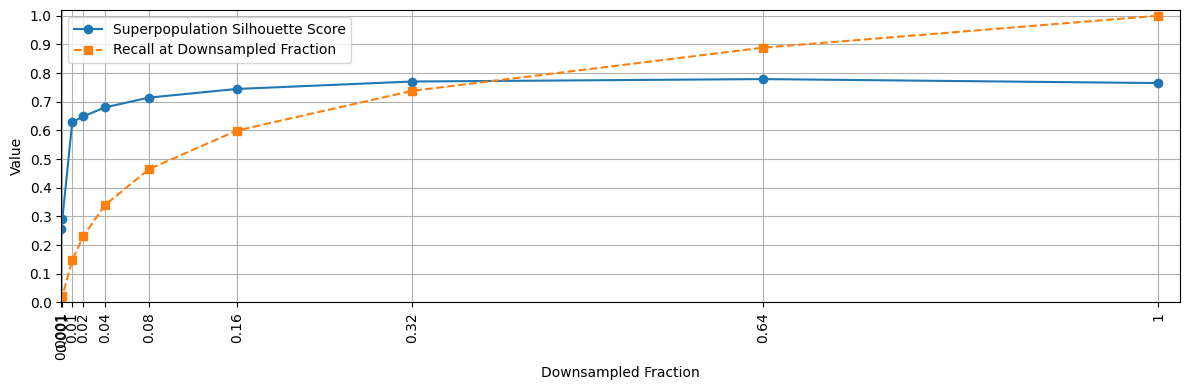

In [32]:
import matplotlib.pyplot as plt
# superpopulation_separation_scores_dict = {0.01: 0.11, 0.10: 0.44, 1.0: 0.98}  # dummy data
# recall_dict = {0.01: 0.05, 0.10: 0.20, 1.0: 1.0}  # dummy data

downsampled_fractions_to_plot = None  # [0.0001, 0.001, 0.01]  # [0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64, 1.0]   # None for all
save_name_suffix = ""  # "" for all

if downsampled_fractions_to_plot is None:
    downsampled_fractions_to_plot = downsampled_fractions

# Sort keys
x = sorted(superpopulation_separation_scores_dict.keys())  #* to only keep values >= 0.01: x = sorted([k for k in superpopulation_separation_scores_dict.keys() if k >= 0.01])
x = [value for value in x if value in downsampled_fractions_to_plot]  #* to only keep values >= 0.01: x = [value for value in x if value >= 0.01]

# Get y-values in same x-order
y_sep = [superpopulation_separation_scores_dict[k] for k in x]
y_recall = [recall_dict[k] for k in x]

# Plot
plt.figure(figsize=(12, 4))
plt.plot(x, y_sep, marker='o', label="Superpopulation Silhouette Score")
plt.plot(x, y_recall, marker='s', linestyle='--', label="Recall at Downsampled Fraction")

plt.xlabel("Downsampled Fraction") 
plt.ylabel("Value")
plt.xticks(x, [f"{v:.3g}" for v in x], rotation=90, ha='center')  # fontsize=9
plt.yticks([i / 10 for i in range(11)])
plt.xlim(0, max(x)*1.02)
plt.ylim(0, 1.02) if min(y_sep) >= 0 else plt.ylim(-1.02, 1.02)

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(out_dir, f"superpopulation_separation_scores_and_recall_vs_downsampled_fraction{save_name_suffix}.pdf"), bbox_inches='tight')
plt.show()
plt.close()